# Font-type Recognition with CNNs using Keras

In [ ]:
import keras

from keras.utils import to_categorical

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

      
print('Keras version: ',keras.__version__)

Keras version:  2.4.3


## <font color= #00cc00>Next cells load the Font Type dataset:</font>


In [ ]:
"""
Load and data
"""

import os
from six.moves import urllib

file_url = 'https://github.com/bloolizard/PlayWithTensorFlow/raw/master/data_with_labels.npz'
file_name = 'data_with_labels.npz'

if not os.path.exists(file_name):
    urllib.request.urlretrieve(file_url, file_name)
    
    
# Load data
data = np.load('data_with_labels.npz')

train = data['arr_0']/255.
labels = data['arr_1']

onehot= to_categorical(labels, num_classes=len(np.unique(labels)))

## Preparing Train/Test Data :
- ### Random Permutation! + split data into training / validation

In [ ]:
# Split data into training (90%) and validation (10%)
np.random.seed(100)

indices = np.random.permutation(train.shape[0])

valid_cnt = int(train.shape[0] * 0.1)

test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
  
test, train = train[test_idx,:],\
              train[training_idx,:]
  
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]


In [ ]:
train=train.reshape([-1,train.shape[1],train.shape[2],1])
test=test.reshape([-1,test.shape[1],test.shape[2],1])

#vgg
num_classes = onehot_test.shape[1]

print('Train shape=', train.shape , '\nTest shape=', test.shape, '\nNum clasess =', num_classes)

Train shape= (2511, 36, 36, 1) 
Test shape= (279, 36, 36, 1) 
Num clasess = 5


## Try CNN / ConvNet models in Keras (remember):

1.   **Define your model**. Create a sequence and add layers.
2.   **Compile your model**. Specify loss functions and optimizers
3.   **Fit your model**. Execute the model using data.
4.   **Make predictions**. Use the model to generate predictions on new data.


## 1.   **Define your ConNet model**:

In [ ]:
from keras.models import Sequential

from keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Input 
#input para vgg
from keras.constraints import maxnorm #vgg

from keras.layers import Convolution2D as Conv2D

#### Simple CNN (using Sequential API)





In [ ]:

'''
model = Sequential()

# TRANSPA(41 del pptx) 
# input: 36x36 images with 1 channel -> (36, 36) tensors.
# this applies 4 convolution filters of size 5x5 each.

model.add(Conv2D(4, (5, 5), activation='relu', input_shape=(36, 36,1)))
# 4 filters for the 4 images of time 5x5 d 

# especify the input shape of the first layer: shpe of the size of original img
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())#take the pooling and put them into a vector
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
'''

#### VGG16 (using Functional API)

In [ ]:
from keras.models import Model #Functional API
#  dropout rate for FC layers
dropout=0.5

# CNN architecture 
# VGG_v1 con 1x1 filters

input_image = Input(shape=(36,36,1))
x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1) #16x16 size

x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1) #8x8

x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(256, (1, 1),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1) #4x4

x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1) #2x2

x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
x1 = Conv2D(512, (1, 1),padding='same', activation='relu')(x1)
#añadido!
x1 = MaxPooling2D((2, 2))(x1) #1x1

x1 = Flatten()(x1)

x1=Dense(4096, activation='relu', kernel_constraint=maxnorm(3))(x1)
x=Dense(4096, activation='relu', kernel_constraint=maxnorm(3))(x1)



x=Dropout(dropout)(x)


out= Dense(num_classes, activation='softmax')(x)

model = Model(inputs = input_image, outputs = out);

## 2.   **Compile your model**. Specify loss functions and optimizers

In [ ]:
from keras.optimizers import SGD


model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [ ]:
model.summary() #dense layer la que mas param tiene entrenados

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 36, 36, 1)]       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 36, 36, 64)        640       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 36, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 18, 18, 128)       147584    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 9, 9, 128)         0   

# 3.   **Fit your model**. Train the model using data.

In [ ]:
# history to analyze training history evolution

# validation_data allows to see evaluation on test while training
history=model.fit(train, onehot_train,
         epochs=100,
         batch_size=128,
         validation_data=(test, onehot_test),
         verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 126ms/step - loss: 1.6094 - accuracy: 0.2123 - val_loss: 1.6103 - val_accuracy: 0.1541
Epoch 2/100
20/20 [==============================] - 1s 63ms/step - loss: 1.6088 - accuracy: 0.2121 - val_loss: 1.6128 - val_accuracy: 0.1541
Epoch 3/100
20/20 [==============================] - 1s 63ms/step - loss: 1.6084 - accuracy: 0.2302 - val_loss: 1.6119 - val_accuracy: 0.3047
Epoch 4/100
20/20 [==============================] - 1s 63ms/step - loss: 1.6084 - accuracy: 0.2570 - val_loss: 1.6119 - val_accuracy: 0.2186
Epoch 5/100
20/20 [==============================] - 1s 63ms/step - loss: 1.6077 - accuracy: 0.2327 - val_loss: 1.6111 - val_accuracy: 0.1541
Epoch 6/100
20/20 [==============================] - 1s 63ms/step - loss: 1.6070 - accuracy: 0.2123 - val_loss: 1.6091 - val_accuracy: 0.2688
Epoch 7/100
20/20 [==============================] - 1s 63ms/step - loss: 1.6046 - accuracy: 0.3694 - val_loss: 1.6057 - val_accuracy: 0.3082
Epoch

## Note:
* another possibility is just specify  $validation\_split$ = 0.10 ... so that 10% (or the % you indicate) of training data is used for validation



In [ ]:
# history to analyze training history evolution

# validation_data allows to see evaluation on test while training
'''
history=model.fit(train, onehot_train,
         epochs=100,
         batch_size=128,
         validation_split = 0.10,
         verbose=1)
'''

## 4.   **Make predictions**. Use the model to generate predictions on new data.

In [ ]:
# Check accuracy on train set

loss_train, accuracy_train = model.evaluate(train, onehot_train, batch_size=128)


print('\nTraining Accuracy=', accuracy_train)

# Check accuracy on test set

loss, accuracy = model.evaluate(test, onehot_test, batch_size=128)


print('\nTest Accuracy=', accuracy)

20/20 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9960

Training Accuracy= 0.9960175156593323
3/3 [==============================] - 0s 3ms/step - loss: 0.1217 - accuracy: 0.9462

Test Accuracy= 0.9462365508079529


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Train Accuracy:  0.95
Test_Accuracy:  0.95


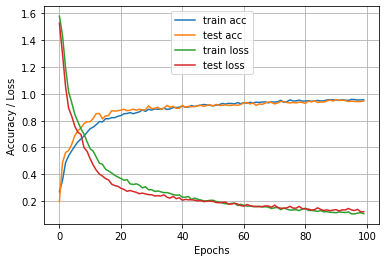

In [ ]:
print('Train Accuracy: ',np.round(history.history['accuracy'][-1],2))
print('Test_Accuracy: ',np.round(history.history['val_accuracy'][-1],2))

# Plot the accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# Plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend(['train acc', 'test acc', 'train loss', 'test loss'], loc='upper center')
plt.grid()

# Get predictions / probabilities ...

In [ ]:
pred_probabilities= model.predict(test)

print('First Five Probs.:\n',pred_probabilities[0:5])

print('\n\nFirst Five Classes:\n',onehot_test[0:5])

First Five Probs.:
 [[9.50736023e-08 4.61282255e-03 1.96712696e-14 1.06155674e-03
  9.94325459e-01]
 [5.44235093e-07 9.99998927e-01 4.59503680e-09 3.98820760e-07
  1.48582117e-07]
 [4.55701666e-13 1.16245625e-04 9.55754882e-25 5.84949667e-05
  9.99825299e-01]
 [9.74981904e-01 3.97693875e-05 2.49783695e-02 7.35262545e-14
  4.25640467e-10]
 [7.76659304e-38 5.28929741e-05 0.00000000e+00 9.99947071e-01
  3.40368705e-12]]


First Five Classes:
 [[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


## Confusion Matrix

Confusion Matrix:
 [[53  1  7  0  0]
 [ 2 68  1  0  0]
 [ 4  0 44  0  0]
 [ 0  0  0 43  0]
 [ 0  0  0  0 56]]


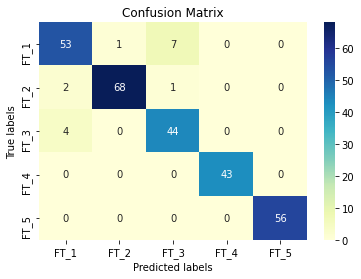

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix as cm

ConfMatrix=cm(np.argmax(onehot_test,1), np.argmax(pred_probabilities,1))

print('Confusion Matrix:\n',ConfMatrix)

ax= plt.subplot()
sns.heatmap(ConfMatrix, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['FT_1', 'FT_2','FT_3','FT_4','FT_5'])
ax.yaxis.set_ticklabels(['FT_1', 'FT_2','FT_3','FT_4','FT_5']);